## Stable Diffusion on SPR with IPEX

This is a demo of [Stable Diffusion with the Hugging Face API](https://huggingface.co/stabilityai), and using the [Intel Extension for PyTorch](https://github.com/intel/intel-extension-for-pytorch) (IPEX) to optimize the model pipeline on Intel's 4th generation Xeon platform.

**Intro to Hardware: 4th Gen Intel® Xeon® Scalable Processor (Sapphire Rapids) - CPU specs**
- Released in January of 2023
- 2 sockets
- 56 physical cores (112 vCPUs) per socket
- 224 vCPUs total
- New Intel® Advanced Matrix Extensions (Intel® AMX), a built-in AI acceleration engine.
    - Supports BF16 and INT8 data types

-----
**PyTorch for CPU** 
- Intel's main goal is to make default PyTorch simple to use and performant on CPUs, by upstreaming all optimizations into the main branch of PyTorch. 
- Uses OpenMP for multi-threading
- Upstreamed oneDNN provides optimized DNN primitives for Intel CPUs

**Intel Extension for PyTorch (IPEX)**
-  Provides additional acceleration that has not yet made it into the stock package
- Early access to optimized kernels
- Runtime extensions
- Mixed precision with BF16 (at the time of writing - should soon be upstreamed into stock). 
    - BF16 data-type requires only half storage of FP32 data-type, which reduces both memory bandwidth and computation when applicable 
- Quantized inference
- Async tasks
- [IPEX GitHub link](https://github.com/intel/intel-extension-for-pytorch) | [IPEX Product page](https://www.intel.com/content/www/us/en/developer/tools/oneapi/optimization-for-pytorch.html#gs.qag6mc)

For more details on oneDNN and BF16, you can take a look at this Medium article, published on 02/03/2021: [Accelerate PyTorch with IPEX and oneDNN using Intel BF16 Technology](https://medium.com/pytorch/accelerate-pytorch-with-ipex-and-onednn-using-intel-bf16-technology-dca5b8e6b58f).



#### Flags for AMX
Under "flags", you can see `amx_bf16`, `amx_tile`, and `amx_int8`, so you know AMX is available for use.

In [25]:
! lscpu 

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         52 bits physical, 57 bits virtual
  Byte Order:            Little Endian
CPU(s):                  224
  On-line CPU(s) list:   0-223
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Platinum 8480+
    CPU family:          6
    Model:               143
    Thread(s) per core:  2
    Core(s) per socket:  56
    Socket(s):           2
    Stepping:            8
    CPU max MHz:         3800.0000
    CPU min MHz:         800.0000
    BogoMIPS:            4000.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes6
   



The demo consists of the following steps:

1. Load and define SD model from HF.
2. Set up and run a standard SD pipeline with the HF API, i.e., generate a FP32 precision image.
3. Optimize SD with IPEX, using Auto Mixed Precision (BF16), and run the pipeline again.
4. Compare the results wrt inference latency time.

#### Environment Setup  

Ensure the ipex_cpu kernel is activated before running this notebook.

If you can't find the ipex_cpu kernel, please go back to terminal and type ```source prepare_env.sh``` to prepare the environments for the workshop.

In [1]:
import torch

from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DPMSolverMultistepScheduler, EulerDiscreteScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import matplotlib.pyplot as plt

import time

# Define model ID for SD version
model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

#### Single image inference

Then, we call the pipeline with a written description of the wanted image, i.e., the text prompt. And generate an image.

The inference process can be made deterministic by setting the generator seed. Furthermore, through the number of inference steps, we can govern the quality of the image, i.e., more steps equals better quality. Reduce the number of steps to receive results faster.

Please experiment with your own prompts!

  0%|          | 0/10 [00:00<?, ?it/s]

Generating one FP32 image took 17.16s


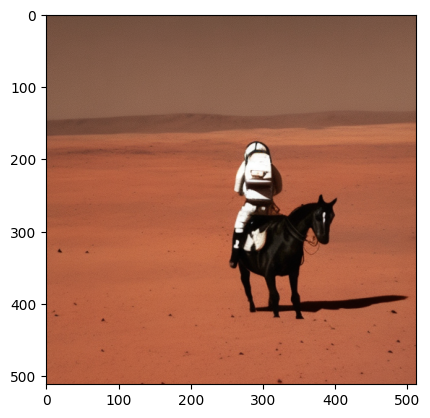

In [2]:
# Define the prompt for the image generation
prompt = "a photo of an astronaut riding a horse on mars"

# Set the number of iterations for the image generation
n_inf_steps = 10

# Simple timing of inference
start = time.time()
image = pipe(prompt, num_inference_steps=n_inf_steps).images[0]
end = time.time()
sd_fp32_t = end-start
print(f"Generating one FP32 image took {round(sd_fp32_t, 2)}s")

image.save("test_FP32.png")
imgplot = plt.imshow(image)
plt.show()

**Optimization with IPEX**

The UNET component of the model architecture is the one that uses most computational resources in the inference process. Hence, with IPEX, we optimize it, and put it in BF16 precision.

In [3]:
import intel_extension_for_pytorch as ipex

infer_dtype = torch.bfloat16

# Put model in eval mode.
pipe.unet.eval()
# text_encoder.eval()

# Optimize the model w/ IPEX
pipe.unet = ipex.optimize(pipe.unet.eval(), dtype=infer_dtype, inplace=True)

/home/u137815/oneapi-devsummit-apj-2023/ipex_cpu/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:474: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
/home/u137815/oneapi-devsummit-apj-2023/ipex_cpu/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:479: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn("Linear BatchNorm folding failed during the optimize process.")


  0%|          | 0/10 [00:00<?, ?it/s]

Generating one BF16 image took 11.63s


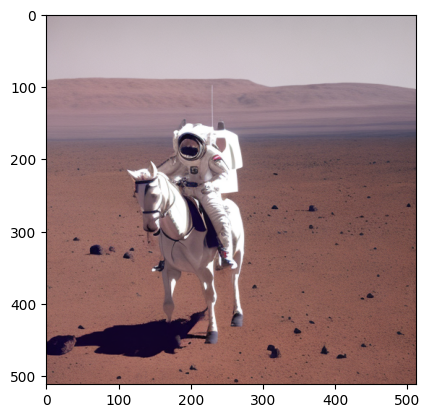

In [4]:
# Simple timing of inference
start = time.time()
with torch.cpu.amp.autocast():
    image = pipe(prompt, num_inference_steps=n_inf_steps).images[0]
end = time.time()
sd_bf16_t = end-start
print(f"Generating one BF16 image took {round(sd_bf16_t, 2)}s")

image.save("test_BF16.png")
imgplot = plt.imshow(image)
plt.show()

We compare the inference speeds between the two runs.

In [5]:
print(f"Inference with IPEX, using AMP+BF16, was {round(sd_fp32_t/sd_bf16_t, 2)}x faster.")

Inference with IPEX, using AMP+BF16, was 1.48x faster.


In [6]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color=['#ffd21e', '#0071c5'],width=0.4)
    plt.xlabel("Model")
    plt.ylabel("Eval inference (seconds); lower is better")
    plt.show()

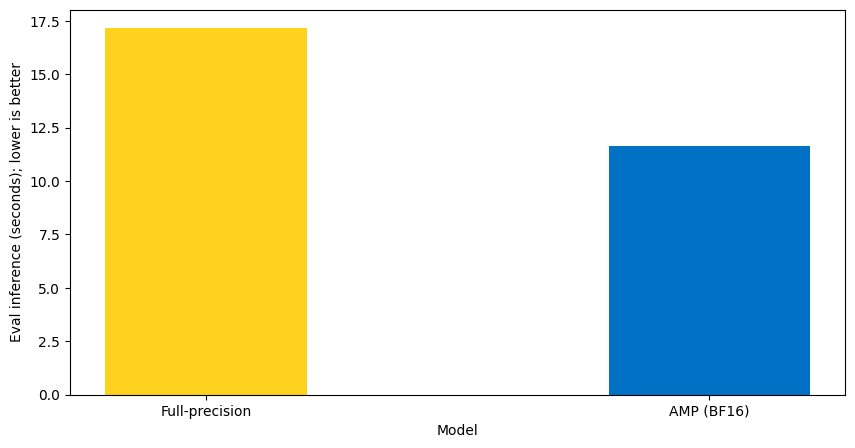

In [7]:
outputDict={"Full-precision":sd_fp32_t,"AMP (BF16)":sd_bf16_t}
plotter(outputDict)